In [71]:

import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline 



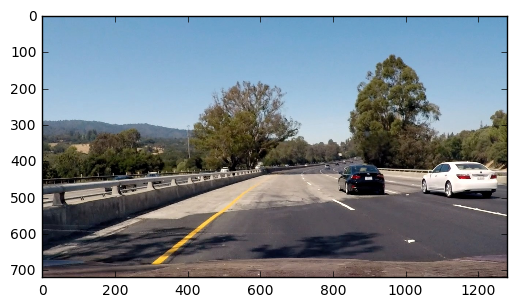

In [72]:
#%matplotlib notebook
image_testing = mpimg.imread('test_images/test4.jpg')
plt.imshow(image_testing)

In [2]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(40, 40))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        #ax.set_xticks([])
        #ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.3, top=0.9, bottom=0.)

    plt.show()

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features




In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [6]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [7]:
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        #print(window_list)
        return window_list



In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    #plt.imshow(feature_image)
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)




In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    counter = 0
    test_images_list = []
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #print(window[0][1],window[1][1])
        #print(window[0][0],window[1][0])
        #print(window)
        #print(img[window[0][1]:window[1][1], window[0][0]:window[1][0]])
        counter += 1
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))      
        test_images_list.append(test_img)
        #plt.imshow(test_img)
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        y_proba = clf.predict_proba(test_features)
        #print(y_proba)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
        #if y_proba[0][1] > 0.7:
        #if True: #
            #print(window)
            #print(counter, y_proba, prediction)
            on_windows.append(window)
            
        #on_windows.append(window) 
    #8) Return windows for positive detections
    return on_windows, test_images_list
    

In [11]:
# Read in cars and notcars
images = glob.glob('train/*.jpeg')
cars = []
notcars = []
for image in images:
    image_name = image.split('/')
    if 'image' in image_name[1] or 'extra' in image_name[1] :
        notcars.append(image)
    else:
        image
        cars.append(image)

sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


def car_classifier(X, y):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC(C=1.0)
    svc = CalibratedClassifierCV(svc) 
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc
    
    
    

In [12]:
svc = car_classifier(scaled_X, y)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 14244
7.53 Seconds to train SVC...
Test Accuracy of SVC =  0.985


In [281]:
def calculate_range_window(hot_window):
    x_list = []
    y_list = []
    hot_window_out = []
    for point1, point2 in hot_window:
        x_list.append(point1)
        y_list.append(point2)
    tolerance_x = (x_list[1]-x_list[0])*1.3
    tolerance_y = (y_list[1]-y_list[0])*1.3
    #print("Tolerance:",tolerance_x,tolerance_y)

    
    for point1, point2 in hot_window:
        pointx_max = point1 + tolerance_x
        pointy_max = point2 + tolerance_y
        pointx_min = point1 - tolerance_x
        pointy_min = point2 - tolerance_y
        hot_window_out.append ((((pointx_min),(pointy_min)), ((pointx_max),(pointy_max) )))
    #print('Range:',hot_window_out)
    return hot_window_out[0], hot_window_out[1]
#hot_windows =[((755, 380), (905, 530)), ((830, 380), (980, 530)), ((1055, 380), (1205, 530)), ((745, 400), (835, 490)), ((835, 400), (925, 490)), ((755, 380), (905, 530)), ((830, 380), (980, 530)), ((1055, 380), (1205, 530))]
#print(len(hot_windows[0]))
#hot_windows_in = hot_windows[0]

#p1, p2 = calculate_range_window(hot_windows_in, 2)

#print(hot_windows_in)
#print(p1, p2)


In [272]:

class Bbox():
    '''Will hndle Bounding Boxes'''
    
    def __init__(self):
        # was a bbox detected in the last frame?
        self.detected = False  
        
        # current position x_start_stop and y_start_stop
        self.list_position = [((),())]  
        
        #count for overlaping windows
        self.count = 0
        

        
        
class Car():
    
    def __init__(self, position, current_frame):
        # was a car detected in the last frame?
        self.position = position #((,),(,))
        self.frame = current_frame
        
    def is_this_the_same(self, hot_window):
        #print(hot_window)
        p1_range, p2_range =  calculate_range_window(self.position)

        x1 = p1_range[0][0]<= hot_window[0][0]<= p1_range[1][0]
        y1 = p1_range[0][1]<= hot_window[0][1]<= p1_range[1][1]

        x2 = p2_range[0][0]<= hot_window[1][0]<= p2_range[1][0]
        y2 = p2_range[0][1]<= hot_window[1][1]<= p2_range[1][1]
        
        if x1 and y1 and x2 and y2:
            #print('Same car')
            return True
        
        else:
            return False
        
    def integrate_extra_window(self, hot_window, current_frame = 0):
        bb_x_start = hot_window[0][0]
        bb_y_start = hot_window[0][1]
        
        bb_x_end = hot_window[1][0]
        bb_y_end = hot_window[1][1]
        
        car_x_start = self.position[0][0]
        car_y_start = self.position[0][1]
        
        car_x_end = self.position[1][0]
        car_y_end = self.position[1][1]
        
        mean_x_start = int(np.mean(list([bb_x_start,car_x_start])))
        mean_y_start = int(np.mean(list([bb_y_start,car_y_start])))
        mean_x_end = int(np.mean(list([bb_x_end,car_x_end])))
        mean_y_end = int(np.mean(list([bb_y_end,car_y_end])))
        
        self.position = ((mean_x_start,mean_y_start),(mean_x_end,mean_y_end))
        
        #return ((mean_x_start,mean_y_start),(mean_x_end,mean_y_end))
        
        self.frame = current_frame
        return self.position 
        
    def discard_old_cars():
        
        pass
    


        


In [270]:

position_car = ((1003, 393), (1113, 503))
position_bbox = ((1129, 380), (1279, 530))
test_car = Car(position_car, 1)
bb_car = Car(position_bbox, 1)

result =test_car.is_this_the_same(bb_car.position)
print(result)

Tolerance: 220 220
Range: [((783, 173), (1223, 613)), ((893, 283), (1333, 723))]
True


In [ ]:
%matplotlib inline
image = mpimg.imread('test_images/test5.jpg')
result = pipeline(image)

plt.imshow(result)


In [284]:
def pipeline(img, current_frame):
    global car_list
    new_hot_windows = []
    new_car_list = []
    windows_to_draw = []

    y_start_stop = [400, 700] # Min and max in y to search in slide_window()
    #windows_all= []
    draw_image = np.copy(img)
    image_size = draw_image.shape
    #print(image_size)
    center_x = 700
    center_y = 440 
    
    windows_small = slide_window(draw_image, x_start_stop=[610, 1110], y_start_stop=[400, 490],
                                 xy_window=(90, 90), xy_overlap=(0.5, 0.5))
    #print(windows_small)
    windows_medium = slide_window(draw_image, x_start_stop=[530, 1280], y_start_stop=[380, 550], 
                                  xy_window=(150, 150), xy_overlap=(0.5, 0.5))
    #windows_all.append(windows_medium)
    windows_big = slide_window(draw_image, x_start_stop=[380, 1280], y_start_stop=[400, 660], 
                    xy_window=(300, 300), xy_overlap=(0.5, 0.5))
    
    #windows_all =  windows_medium  + windows_small +  windows_medium + windows_big
    windows_all =  windows_medium  + windows_small + windows_big
    #windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    #xy_windowimage=(80, 80), xy_overlap=(0.5, 0.5))

    hot_windows, x = search_windows(draw_image, windows_all, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
    
    #print(len(hot_windows))
    if len(hot_windows)> 0:
        Bbox.detected = True
        hot_window_taken = False
        for hot_window in hot_windows:
            #print('window',hot_window)
            for car in car_list:
                if car.is_this_the_same(hot_window):
                    
                    new_hot_window = car.integrate_extra_window(hot_window,current_frame)
                    #print('new car position:',new_hot_window)
                    
                    hot_window_taken = True
                    break
                else:
                    hot_window_taken = False
            if not hot_window_taken:
                #print('not taken', hot_window)
                new_car = Car(hot_window, current_frame)
                car_list.append(new_car)
                
                #Clean old cars
                #car_list.discard_old_cars
        
    #print(hot_windows)
    #window_img_b = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    #if len(new_hot_windows) > 0:
    counter_car = 0
    for car in car_list:
        
        if current_frame - car.frame <= 4:
            #print(car.frame)
            new_hot_windows.append(car.position)
            new_car_list.append(car)
            
        else:            
            #print(len(car_list))
            pass
            
    car_list = new_car_list
    
    #TODO: Iterate throgh the list of car again to see if I had boxes that are the same car            
    for hot_window in new_hot_windows:
        #print('window',hot_window)
        for car in car_list:
            if car.is_this_the_same(hot_window):
                windows_to_draw.append(hot_window)
                
            else:
                print('Not the same', car.position, hot_window)
                    
            
        
        
    
        
    window_img = draw_boxes(draw_image, windows_to_draw, color=(255, 0, 0), thick=6)  
    #plt.imshow(window_img)
    return window_img



Processing image test_images/test5.jpg
[((755, 380), (905, 530)), ((830, 380), (980, 530)), ((1055, 380), (1205, 530)), ((835, 400), (925, 490))]
Processing image test_images/test5.jpg
[((755, 380), (905, 530)), ((830, 380), (980, 530)), ((1055, 380), (1205, 530)), ((835, 400), (925, 490))]
Processing image test_images/test2.jpg
[]


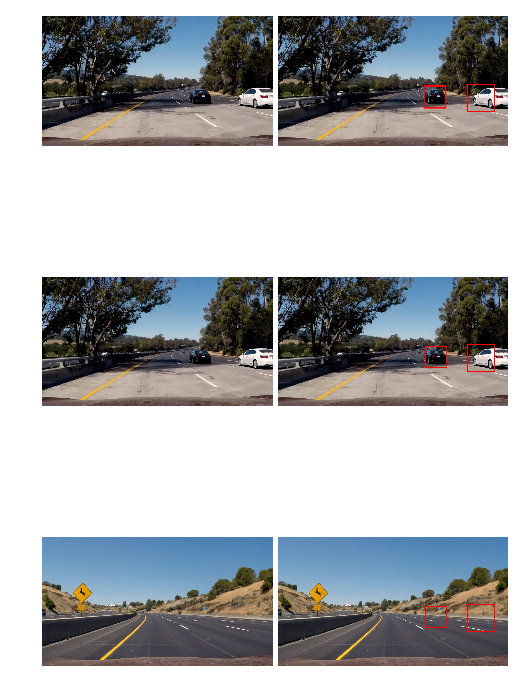

In [231]:
car_list = []
images = glob.glob("test_images/*.jpg")
images.sort()
images_test = images[4:5]+ images[4:5]+ images[1:2] 
# Setup the plot grid for test images
plt.figure(figsize = (len(images),20))
gs1 = gridspec.GridSpec(len(images),2)
gs1.update(wspace=0.025, hspace=0.05)
i=0
frame = 0
for fname in images_test:
    frame += 1
    print("Processing image {}".format(fname))
    
    # Next, let's read in a test image
    img = mpimg.imread(fname)
    # Process the image using our pipeline
    combined_img = pipeline(img, frame)
    
    # Plot the original image and the processed images
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img)
    ax2 = plt.subplot(gs1[i+1])
    plt.axis('off')
    ax2.imshow(combined_img)
    i += 2
plt.show()


In [172]:
print(len(car_list))
print(car_list[0].position)
print(car_list[1].position)

print(car_list[0].frame)
print(car_list[1].frame)

2
((808, 382), (951, 524))
((1055, 380), (1205, 530))
3
3


In [287]:
car_list = []
counter = 0
def counter_frames(image):
    global counter
    img = image
    
    result = pipeline(img,counter )
    counter +=1
    #print(counter)
    
    return result



In [ ]:
#To process the video 
output = 'output_DIFF.mp4'
#output = 'output_hard.mp4'
#file = VideoFileClip("hard.mp4");
file = VideoFileClip("project_video.mp4");

out = file.fl_image(pipeline) #NOTE: this function expects color images!!
%time out.write_videofile(output, audio=False);

In [288]:
#To process the video 
output = 'output_counter_3.mp4'
#output = 'output_hard.mp4'
#file = VideoFileClip("hard.mp4");
file = VideoFileClip("project_video.mp4");

out = file.fl_image(counter_frames) #NOTE: this function expects color images!!
%time out.write_videofile(output, audio=False);

[MoviePy] >>>> Building video output_counter_3.mp4
[MoviePy] Writing video output_counter_3.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 2/1261 [00:00<01:51, 11.28it/s]




  0%|          | 4/1261 [00:00<01:44, 12.05it/s]




  0%|          | 6/1261 [00:00<01:54, 10.92it/s]




  1%|          | 7/1261 [00:00<02:02, 10.24it/s]




  1%|          | 8/1261 [00:00<02:10,  9.62it/s]




  1%|          | 9/1261 [00:00<02:08,  9.72it/s]




  1%|          | 11/1261 [00:01<02:06,  9.92it/s]




  1%|          | 12/1261 [00:01<02:13,  9.36it/s]




  1%|          | 14/1261 [00:01<02:03, 10.10it/s]




  1%|▏         | 16/1261 [00:01<01:51, 11.15it/s]




  1%|▏         | 18/1261 [00:01<01:43, 12.03it/s]




  2%|▏         | 20/1261 [00:01<01:38, 12.54it/s]




  2%|▏         | 22/1261 [00:01<01:34, 13.10it/s]




  2%|▏         | 24/1261 [00:02<01:31, 13.48it/s]




  2%|▏         | 26/1261 [00:02<01:29, 13.73it/s]




  2%|▏         | 28/1261 [00:02<01:28, 13.96it/s]




  2%|▏         | 30/1261 [00:02<01:27, 14.11it/s]




  3%|▎         | 32/1261 [00:02<01:26,

Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))







 47%|████▋     | 595/1261 [00:58<01:20,  8.24it/s]




 47%|████▋     | 597/1261 [00:58<01:15,  8.77it/s]

Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))







 48%|████▊     | 599/1261 [00:58<01:09,  9.49it/s]




 48%|████▊     | 600/1261 [00:58<01:12,  9.15it/s]

Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))







 48%|████▊     | 601/1261 [00:58<01:14,  8.86it/s]




 48%|████▊     | 602/1261 [00:59<01:15,  8.78it/s]

Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))







 48%|████▊     | 603/1261 [00:59<01:17,  8.53it/s]




 48%|████▊     | 605/1261 [00:59<01:10,  9.27it/s]

Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))
Not the same ((745, 400), (835, 490)) ((910, 399), (1000, 490))
Not the same ((910, 399), (1000, 490)) ((745, 400), (835, 490))







 48%|████▊     | 606/1261 [00:59<01:13,  8.87it/s]




 48%|████▊     | 607/1261 [00:59<01:15,  8.61it/s]




 48%|████▊     | 609/1261 [00:59<01:08,  9.52it/s]




 48%|████▊     | 610/1261 [00:59<01:09,  9.41it/s]




 49%|████▊     | 612/1261 [01:00<01:04, 10.11it/s]




 49%|████▊     | 614/1261 [01:00<01:01, 10.53it/s]




 49%|████▉     | 616/1261 [01:00<01:01, 10.55it/s]




 49%|████▉     | 618/1261 [01:00<01:01, 10.52it/s]




 49%|████▉     | 620/1261 [01:00<01:00, 10.67it/s]




 49%|████▉     | 622/1261 [01:00<00:59, 10.68it/s]




 49%|████▉     | 624/1261 [01:01<01:03, 10.06it/s]




 50%|████▉     | 626/1261 [01:01<01:01, 10.25it/s]




 50%|████▉     | 628/1261 [01:01<01:01, 10.29it/s]




 50%|████▉     | 630/1261 [01:01<01:02, 10.11it/s]




 50%|█████     | 632/1261 [01:01<01:01, 10.25it/s]




 50%|█████     | 634/1261 [01:02<01:00, 10.40it/s]




 50%|█████     | 636/1261 [01:02<00:57, 10.90it/s]




 51%|█████     | 638/1261 [01:02<00:59, 10.46it/s]




 51%|

Not the same ((880, 400), (970, 490)) ((1058, 380), (1208, 530))
Not the same ((1058, 380), (1208, 530)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1056, 380), (1206, 530))
Not the same ((1056, 380), (1206, 530)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((880, 400), (970, 490))







 58%|█████▊    | 732/1261 [01:11<00:48, 10.96it/s]

Not the same ((880, 400), (970, 490)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1053, 390), (1173, 510))
Not the same ((1053, 390), (1173, 510)) ((880, 400), (970, 490))







 58%|█████▊    | 734/1261 [01:11<00:47, 11.19it/s]




 58%|█████▊    | 736/1261 [01:11<00:48, 10.90it/s]

Not the same ((880, 400), (970, 490)) ((1053, 391), (1169, 507))
Not the same ((1053, 391), (1169, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▊    | 738/1261 [01:12<00:47, 11.07it/s]

Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▊    | 740/1261 [01:12<00:46, 11.30it/s]

Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▉    | 742/1261 [01:12<00:47, 10.90it/s]




 59%|█████▉    | 744/1261 [01:12<00:50, 10.33it/s]

Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▉    | 746/1261 [01:12<00:50, 10.16it/s]

Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▉    | 748/1261 [01:13<00:51, 10.01it/s]

Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1048, 390), (1166, 508))
Not the same ((1048, 390), (1166, 508)) ((880, 400), (970, 490))







 59%|█████▉    | 750/1261 [01:13<00:52,  9.74it/s]

Not the same ((880, 400), (970, 490)) ((1024, 391), (1140, 507))
Not the same ((1024, 391), (1140, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))







 60%|█████▉    | 752/1261 [01:13<00:51,  9.94it/s]




 60%|█████▉    | 753/1261 [01:13<00:52,  9.75it/s]

Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))







 60%|█████▉    | 754/1261 [01:13<00:53,  9.48it/s]




 60%|█████▉    | 755/1261 [01:13<00:53,  9.54it/s]

Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))







 60%|█████▉    | 756/1261 [01:13<00:52,  9.65it/s]




 60%|██████    | 757/1261 [01:14<00:52,  9.65it/s]

Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))







 60%|██████    | 758/1261 [01:14<00:52,  9.66it/s]




 60%|██████    | 760/1261 [01:14<00:49, 10.08it/s]

Not the same ((880, 400), (970, 490)) ((1021, 391), (1137, 507))
Not the same ((1021, 391), (1137, 507)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1006, 395), (1109, 498))
Not the same ((1006, 395), (1109, 498)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1006, 395), (1108, 498))
Not the same ((1006, 395), (1108, 498)) ((880, 400), (970, 490))







 60%|██████    | 762/1261 [01:14<00:47, 10.40it/s]

Not the same ((880, 400), (970, 490)) ((1006, 395), (1108, 498))
Not the same ((1006, 395), (1108, 498)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1006, 395), (1108, 498))
Not the same ((1006, 395), (1108, 498)) ((880, 400), (970, 490))
Not the same ((880, 400), (970, 490)) ((1006, 395), (1108, 498))
Not the same ((1006, 395), (1108, 498)) ((880, 400), (970, 490))







 61%|██████    | 764/1261 [01:14<00:49, 10.02it/s]




 61%|██████    | 766/1261 [01:14<00:48, 10.20it/s]

Not the same ((880, 400), (970, 490)) ((997, 391), (1111, 506))
Not the same ((880, 400), (970, 490)) ((995, 391), (1111, 507))
Not the same ((880, 400), (970, 490)) ((995, 391), (1111, 507))







 61%|██████    | 768/1261 [01:15<00:48, 10.24it/s]

Not the same ((880, 400), (970, 490)) ((995, 391), (1111, 507))







 61%|██████    | 770/1261 [01:15<00:48, 10.23it/s]




 61%|██████    | 772/1261 [01:15<00:47, 10.28it/s]

Not the same ((880, 400), (970, 490)) ((987, 390), (1104, 508))
Not the same ((880, 400), (970, 490)) ((989, 390), (1107, 508))







 61%|██████▏   | 774/1261 [01:15<00:46, 10.48it/s]




 62%|██████▏   | 776/1261 [01:15<00:47, 10.16it/s]




 62%|██████▏   | 778/1261 [01:16<00:46, 10.33it/s]




 62%|██████▏   | 780/1261 [01:16<00:47, 10.18it/s]




 62%|██████▏   | 782/1261 [01:16<00:52,  9.17it/s]




 62%|██████▏   | 783/1261 [01:16<00:53,  9.02it/s]




 62%|██████▏   | 784/1261 [01:16<00:56,  8.44it/s]




 62%|██████▏   | 785/1261 [01:16<01:01,  7.78it/s]




 62%|██████▏   | 786/1261 [01:17<01:00,  7.86it/s]




 62%|██████▏   | 787/1261 [01:17<01:02,  7.56it/s]




 62%|██████▏   | 788/1261 [01:17<01:01,  7.64it/s]




 63%|██████▎   | 789/1261 [01:17<01:04,  7.36it/s]




 63%|██████▎   | 790/1261 [01:17<01:04,  7.34it/s]




 63%|██████▎   | 791/1261 [01:17<01:06,  7.03it/s]




 63%|██████▎   | 792/1261 [01:17<01:04,  7.28it/s]




 63%|██████▎   | 793/1261 [01:18<01:04,  7.28it/s]




 63%|██████▎   | 794/1261 [01:18<01:06,  7.00it/s]




 63%|██████▎   | 795/1261 [01:18<01:10,  6.64it/s]




 63%|

Not the same ((835, 400), (925, 490)) ((986, 381), (1131, 527))
Not the same ((986, 381), (1131, 527)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((999, 380), (1148, 529))
Not the same ((999, 380), (1148, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((1001, 380), (1151, 529))
Not the same ((1001, 380), (1151, 529)) ((835, 400), (925, 490))







 75%|███████▍  | 944/1261 [01:35<00:29, 10.60it/s]

Not the same ((835, 400), (925, 490)) ((1001, 380), (1151, 529))
Not the same ((1001, 380), (1151, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((1001, 380), (1151, 529))
Not the same ((1001, 380), (1151, 529)) ((835, 400), (925, 490))







 75%|███████▌  | 946/1261 [01:35<00:31, 10.16it/s]




 75%|███████▌  | 948/1261 [01:35<00:30, 10.23it/s]

Not the same ((835, 400), (925, 490)) ((1001, 380), (1151, 529))
Not the same ((1001, 380), (1151, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((1001, 380), (1151, 529))
Not the same ((1001, 380), (1151, 529)) ((835, 400), (925, 490))







 75%|███████▌  | 950/1261 [01:36<00:29, 10.49it/s]

Not the same ((835, 400), (925, 490)) ((985, 381), (1131, 527))
Not the same ((985, 381), (1131, 527)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((981, 380), (1130, 529))
Not the same ((981, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 75%|███████▌  | 952/1261 [01:36<00:29, 10.59it/s]




 76%|███████▌  | 954/1261 [01:36<00:27, 10.98it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 76%|███████▌  | 956/1261 [01:36<00:29, 10.25it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 76%|███████▌  | 958/1261 [01:36<00:33,  8.94it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 76%|███████▌  | 959/1261 [01:37<00:34,  8.69it/s]




 76%|███████▌  | 960/1261 [01:37<00:34,  8.73it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 76%|███████▌  | 961/1261 [01:37<00:33,  8.92it/s]




 76%|███████▋  | 962/1261 [01:37<00:33,  8.91it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 76%|███████▋  | 963/1261 [01:37<00:35,  8.51it/s]




 76%|███████▋  | 964/1261 [01:37<00:34,  8.69it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 77%|███████▋  | 965/1261 [01:37<00:38,  7.72it/s]




 77%|███████▋  | 966/1261 [01:37<00:38,  7.71it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))







 77%|███████▋  | 967/1261 [01:38<00:38,  7.67it/s]




 77%|███████▋  | 968/1261 [01:38<00:36,  8.13it/s]

Not the same ((835, 400), (925, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((835, 400), (925, 490))
Not the same ((823, 400), (913, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((823, 400), (913, 490))
Not the same ((829, 400), (919, 490)) ((980, 380), (1130, 529))
Not the same ((980, 380), (1130, 529)) ((829, 400), (919, 490))







 77%|███████▋  | 970/1261 [01:38<00:34,  8.44it/s]




 77%|███████▋  | 971/1261 [01:38<00:32,  8.81it/s]

Not the same ((832, 400), (922, 490)) ((997, 390), (1117, 509))
Not the same ((997, 390), (1117, 509)) ((832, 400), (922, 490))
Not the same ((833, 395), (938, 500)) ((1026, 385), (1161, 519))
Not the same ((1026, 385), (1161, 519)) ((833, 395), (938, 500))







 77%|███████▋  | 972/1261 [01:38<00:32,  8.97it/s]




 77%|███████▋  | 973/1261 [01:38<00:32,  8.88it/s]

Not the same ((822, 396), (922, 496)) ((1040, 382), (1183, 524))
Not the same ((1040, 382), (1183, 524)) ((822, 396), (922, 496))
Not the same ((830, 394), (938, 501)) ((1047, 381), (1194, 527))
Not the same ((1047, 381), (1194, 527)) ((830, 394), (938, 501))







 77%|███████▋  | 974/1261 [01:38<00:34,  8.41it/s]




 77%|███████▋  | 975/1261 [01:39<00:33,  8.58it/s]

Not the same ((832, 393), (942, 502)) ((1051, 380), (1199, 528))
Not the same ((1051, 380), (1199, 528)) ((832, 393), (942, 502))
Not the same ((833, 393), (943, 503)) ((1053, 380), (1202, 529))
Not the same ((1053, 380), (1202, 529)) ((833, 393), (943, 503))







 77%|███████▋  | 976/1261 [01:39<00:32,  8.77it/s]




 77%|███████▋  | 977/1261 [01:39<00:33,  8.48it/s]

Not the same ((833, 393), (943, 503)) ((1054, 380), (1203, 529))
Not the same ((1054, 380), (1203, 529)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))







 78%|███████▊  | 978/1261 [01:39<00:34,  8.25it/s]




 78%|███████▊  | 980/1261 [01:39<00:31,  8.89it/s]

Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))







 78%|███████▊  | 981/1261 [01:39<00:33,  8.29it/s]




 78%|███████▊  | 982/1261 [01:39<00:33,  8.24it/s]

Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1054, 380), (1204, 529))
Not the same ((1054, 380), (1204, 529)) ((833, 393), (943, 503))







 78%|███████▊  | 983/1261 [01:39<00:34,  8.09it/s]




 78%|███████▊  | 985/1261 [01:40<00:31,  8.67it/s]




 78%|███████▊  | 987/1261 [01:40<00:30,  9.04it/s]




 78%|███████▊  | 988/1261 [01:40<00:32,  8.50it/s]




 78%|███████▊  | 989/1261 [01:40<00:32,  8.46it/s]




 79%|███████▊  | 990/1261 [01:40<00:33,  8.19it/s]




 79%|███████▊  | 991/1261 [01:40<00:32,  8.33it/s]




 79%|███████▊  | 992/1261 [01:40<00:32,  8.15it/s]




 79%|███████▊  | 993/1261 [01:41<00:32,  8.22it/s]




 79%|███████▉  | 994/1261 [01:41<00:34,  7.73it/s]




 79%|███████▉  | 995/1261 [01:41<00:34,  7.65it/s]

Not the same ((1055, 380), (1205, 530)) ((821, 397), (920, 495))
Not the same ((821, 397), (920, 495)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((830, 394), (937, 501))
Not the same ((830, 394), (937, 501)) ((1055, 380), (1205, 530))







 79%|███████▉  | 996/1261 [01:41<00:35,  7.44it/s]




 79%|███████▉  | 997/1261 [01:41<00:35,  7.53it/s]

Not the same ((1055, 380), (1205, 530)) ((832, 393), (941, 502))
Not the same ((832, 393), (941, 502)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((822, 396), (922, 496))
Not the same ((822, 396), (922, 496)) ((1055, 380), (1205, 530))







 79%|███████▉  | 998/1261 [01:41<00:33,  7.82it/s]




 79%|███████▉  | 999/1261 [01:41<00:32,  8.15it/s]

Not the same ((1055, 380), (1205, 530)) ((821, 397), (920, 495))
Not the same ((821, 397), (920, 495)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((830, 394), (937, 501))
Not the same ((830, 394), (937, 501)) ((1055, 380), (1205, 530))







 79%|███████▉  | 1000/1261 [01:41<00:32,  7.95it/s]




 79%|███████▉  | 1001/1261 [01:42<00:32,  8.08it/s]

Not the same ((1055, 380), (1205, 530)) ((817, 395), (920, 498))
Not the same ((817, 395), (920, 498)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((821, 391), (935, 506))
Not the same ((821, 391), (935, 506)) ((1055, 380), (1205, 530))







 79%|███████▉  | 1002/1261 [01:42<00:35,  7.28it/s]




 80%|███████▉  | 1003/1261 [01:42<00:35,  7.27it/s]

Not the same ((1055, 380), (1205, 530)) ((830, 392), (941, 504))
Not the same ((830, 392), (941, 504)) ((1055, 380), (1205, 530))







 80%|███████▉  | 1004/1261 [01:42<00:34,  7.41it/s]




 80%|███████▉  | 1005/1261 [01:42<00:37,  6.79it/s]

Not the same ((1092, 380), (1242, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1092, 380), (1242, 530))
Not the same ((1101, 380), (1251, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1101, 380), (1251, 530))







 80%|███████▉  | 1006/1261 [01:42<00:36,  7.07it/s]




 80%|███████▉  | 1007/1261 [01:43<00:37,  6.73it/s]

Not the same ((1104, 380), (1254, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1104, 380), (1254, 530))
Not the same ((1117, 380), (1267, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1117, 380), (1267, 530))







 80%|███████▉  | 1008/1261 [01:43<00:35,  7.06it/s]

Not the same ((1108, 380), (1258, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1108, 380), (1258, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 80%|████████  | 1009/1261 [01:43<00:40,  6.26it/s]




 80%|████████  | 1010/1261 [01:43<00:38,  6.48it/s]




 80%|████████  | 1011/1261 [01:43<00:39,  6.39it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 80%|████████  | 1012/1261 [01:43<00:38,  6.43it/s]




 80%|████████  | 1013/1261 [01:43<00:37,  6.57it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 80%|████████  | 1014/1261 [01:44<00:36,  6.81it/s]




 80%|████████  | 1015/1261 [01:44<00:35,  6.98it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 81%|████████  | 1016/1261 [01:44<00:34,  7.00it/s]




 81%|████████  | 1017/1261 [01:44<00:33,  7.26it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 81%|████████  | 1018/1261 [01:44<00:33,  7.33it/s]




 81%|████████  | 1019/1261 [01:44<00:32,  7.38it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))







 81%|████████  | 1020/1261 [01:44<00:30,  7.99it/s]




 81%|████████  | 1021/1261 [01:44<00:30,  7.97it/s]

Not the same ((1105, 380), (1255, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1105, 380), (1255, 530))
Not the same ((1080, 380), (1230, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1080, 380), (1230, 530))







 81%|████████  | 1022/1261 [01:45<00:33,  7.18it/s]




 81%|████████  | 1023/1261 [01:45<00:33,  7.11it/s]

Not the same ((1067, 380), (1217, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1067, 380), (1217, 530))
Not the same ((1061, 380), (1211, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1061, 380), (1211, 530))







 81%|████████  | 1024/1261 [01:45<00:32,  7.22it/s]




 81%|████████▏ | 1025/1261 [01:45<00:33,  6.98it/s]

Not the same ((1058, 380), (1208, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1058, 380), (1208, 530))
Not the same ((1056, 380), (1206, 530)) ((811, 396), (911, 496))
Not the same ((811, 396), (911, 496)) ((1056, 380), (1206, 530))







 81%|████████▏ | 1026/1261 [01:45<00:34,  6.80it/s]

Not the same ((1055, 380), (1205, 530)) ((810, 398), (905, 492))
Not the same ((810, 398), (905, 492)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((810, 398), (904, 492))
Not the same ((810, 398), (904, 492)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((820, 397), (918, 495))
Not the same ((820, 397), (918, 495)) ((1055, 380), (1205, 530))







 82%|████████▏ | 1028/1261 [01:45<00:30,  7.52it/s]




 82%|████████▏ | 1029/1261 [01:46<00:30,  7.61it/s]




 82%|████████▏ | 1031/1261 [01:46<00:27,  8.48it/s]

Not the same ((1055, 380), (1205, 530)) ((830, 394), (937, 501))
Not the same ((830, 394), (937, 501)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((832, 393), (941, 502))
Not the same ((832, 393), (941, 502)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((823, 391), (938, 506))
Not the same ((823, 391), (938, 506)) ((1055, 380), (1205, 530))







 82%|████████▏ | 1033/1261 [01:46<00:25,  8.82it/s]

Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))







 82%|████████▏ | 1035/1261 [01:46<00:25,  8.95it/s]




 82%|████████▏ | 1036/1261 [01:46<00:25,  8.93it/s]

Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))







 82%|████████▏ | 1037/1261 [01:46<00:28,  7.98it/s]




 82%|████████▏ | 1038/1261 [01:47<00:31,  7.05it/s]

Not the same ((1055, 380), (1205, 530)) ((822, 391), (937, 507))
Not the same ((822, 391), (937, 507)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((830, 392), (941, 504))
Not the same ((830, 392), (941, 504)) ((1055, 380), (1205, 530))







 82%|████████▏ | 1040/1261 [01:47<00:28,  7.81it/s]

Not the same ((1055, 380), (1205, 530)) ((832, 393), (942, 503))
Not the same ((832, 393), (942, 503)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))







 83%|████████▎ | 1042/1261 [01:47<00:25,  8.45it/s]




 83%|████████▎ | 1043/1261 [01:47<00:25,  8.56it/s]

Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))







 83%|████████▎ | 1045/1261 [01:47<00:23,  9.35it/s]

Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))
Not the same ((1055, 380), (1205, 530)) ((833, 393), (943, 503))
Not the same ((833, 393), (943, 503)) ((1055, 380), (1205, 530))
Not the same ((1092, 380), (1242, 530)) ((823, 391), (938, 506))
Not the same ((823, 391), (938, 506)) ((1092, 380), (1242, 530))







 83%|████████▎ | 1047/1261 [01:47<00:21, 10.00it/s]




 83%|████████▎ | 1049/1261 [01:48<00:20, 10.44it/s]

Not the same ((1092, 380), (1242, 530)) ((830, 392), (942, 504))
Not the same ((830, 392), (942, 504)) ((1092, 380), (1242, 530))
Not the same ((1092, 380), (1242, 530)) ((823, 391), (938, 506))
Not the same ((823, 391), (938, 506)) ((1092, 380), (1242, 530))
Not the same ((1092, 380), (1242, 530)) ((829, 395), (931, 498))
Not the same ((829, 395), (931, 498)) ((1092, 380), (1242, 530))







 83%|████████▎ | 1051/1261 [01:48<00:21,  9.97it/s]

Not the same ((1092, 380), (1242, 530)) ((832, 397), (928, 494))
Not the same ((832, 397), (928, 494)) ((1092, 380), (1242, 530))







 84%|████████▎ | 1053/1261 [01:48<00:20, 10.02it/s]




 84%|████████▎ | 1055/1261 [01:48<00:19, 10.61it/s]




 84%|████████▍ | 1057/1261 [01:48<00:18, 10.87it/s]




 84%|████████▍ | 1059/1261 [01:49<00:19, 10.55it/s]




 84%|████████▍ | 1061/1261 [01:49<00:19, 10.49it/s]




 84%|████████▍ | 1063/1261 [01:49<00:18, 10.53it/s]




 84%|████████▍ | 1065/1261 [01:49<00:17, 11.02it/s]




 85%|████████▍ | 1067/1261 [01:49<00:17, 11.21it/s]




 85%|████████▍ | 1069/1261 [01:49<00:17, 10.70it/s]




 85%|████████▍ | 1071/1261 [01:50<00:17, 10.90it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 396), (910, 496))
Not the same ((810, 396), (910, 496)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((808, 394), (916, 501))
Not the same ((808, 394), (916, 501)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((808, 393), (917, 502))
Not the same ((808, 393), (917, 502)) ((1130, 380), (1280, 530))







 85%|████████▌ | 1073/1261 [01:50<00:17, 10.79it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 396), (910, 496))
Not the same ((810, 396), (910, 496)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((822, 398), (917, 493))
Not the same ((822, 398), (917, 493)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((820, 399), (911, 490))
Not the same ((820, 399), (911, 490)) ((1130, 380), (1280, 530))







 85%|████████▌ | 1075/1261 [01:50<00:17, 10.45it/s]




 85%|████████▌ | 1077/1261 [01:50<00:16, 10.85it/s]

Not the same ((1130, 380), (1280, 530)) ((820, 399), (910, 490))
Not the same ((820, 399), (910, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((811, 394), (916, 500))
Not the same ((811, 394), (916, 500)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 396), (910, 496))
Not the same ((810, 396), (910, 496)) ((1130, 380), (1280, 530))







 86%|████████▌ | 1079/1261 [01:50<00:17, 10.38it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))







 86%|████████▌ | 1081/1261 [01:51<00:17, 10.43it/s]

Not the same ((1130, 380), (1280, 530)) ((808, 394), (916, 501))
Not the same ((808, 394), (916, 501)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((821, 397), (920, 495))
Not the same ((821, 397), (920, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((811, 394), (918, 501))
Not the same ((811, 394), (918, 501)) ((1130, 380), (1280, 530))







 86%|████████▌ | 1083/1261 [01:51<00:17, 10.25it/s]

Not the same ((1130, 380), (1280, 530)) ((823, 397), (921, 495))
Not the same ((823, 397), (921, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((829, 398), (923, 492))
Not the same ((829, 398), (923, 492)) ((1130, 380), (1280, 530))







 86%|████████▌ | 1085/1261 [01:51<00:17, 10.05it/s]




 86%|████████▌ | 1087/1261 [01:51<00:16, 10.49it/s]

Not the same ((1130, 380), (1280, 530)) ((832, 399), (924, 491))
Not the same ((832, 399), (924, 491)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((833, 399), (924, 490))
Not the same ((833, 399), (924, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((834, 399), (924, 490))
Not the same ((834, 399), (924, 490)) ((1130, 380), (1280, 530))







 86%|████████▋ | 1089/1261 [01:51<00:16, 10.57it/s]

Not the same ((1130, 380), (1280, 530)) ((823, 399), (913, 490))
Not the same ((823, 399), (913, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((812, 397), (909, 495))
Not the same ((812, 397), (909, 495)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1091/1261 [01:52<00:16, 10.03it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1093/1261 [01:52<00:16, 10.02it/s]

Not the same ((1130, 380), (1280, 530)) ((817, 399), (909, 491))
Not the same ((817, 399), (909, 491)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((811, 397), (909, 495))
Not the same ((811, 397), (909, 495)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1095/1261 [01:52<00:17,  9.69it/s]

Not the same ((1130, 380), (1280, 530)) ((809, 394), (916, 501))
Not the same ((809, 394), (916, 501)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((822, 397), (920, 495))
Not the same ((822, 397), (920, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((828, 398), (922, 492))
Not the same ((828, 398), (922, 492)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1097/1261 [01:52<00:16,  9.82it/s]




 87%|████████▋ | 1099/1261 [01:52<00:16, 10.06it/s]

Not the same ((1130, 380), (1280, 530)) ((831, 399), (923, 491))
Not the same ((831, 399), (923, 491)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((833, 399), (924, 490))
Not the same ((833, 399), (924, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((823, 399), (913, 490))
Not the same ((823, 399), (913, 490)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1101/1261 [01:53<00:15, 10.19it/s]

Not the same ((1130, 380), (1280, 530)) ((820, 399), (910, 490))
Not the same ((820, 399), (910, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((811, 397), (909, 495))
Not the same ((811, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((809, 394), (916, 501))
Not the same ((809, 394), (916, 501)) ((1130, 380), (1280, 530))







 87%|████████▋ | 1103/1261 [01:53<00:15, 10.06it/s]




 88%|████████▊ | 1105/1261 [01:53<00:14, 10.67it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 396), (910, 496))
Not the same ((810, 396), (910, 496)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((817, 399), (909, 491))
Not the same ((817, 399), (909, 491)) ((1130, 380), (1280, 530))







 88%|████████▊ | 1107/1261 [01:53<00:13, 11.18it/s]

Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))







 88%|████████▊ | 1109/1261 [01:53<00:13, 11.16it/s]




 88%|████████▊ | 1111/1261 [01:54<00:13, 10.94it/s]

Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((819, 399), (909, 490))
Not the same ((819, 399), (909, 490)) ((1130, 380), (1280, 530))







 88%|████████▊ | 1113/1261 [01:54<00:13, 10.62it/s]

Not the same ((1130, 380), (1280, 530)) ((811, 397), (909, 495))
Not the same ((811, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))







 88%|████████▊ | 1115/1261 [01:54<00:13, 10.72it/s]




 89%|████████▊ | 1117/1261 [01:54<00:13, 10.72it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))







 89%|████████▊ | 1119/1261 [01:54<00:13, 10.33it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))







 89%|████████▉ | 1121/1261 [01:54<00:13, 10.58it/s]




 89%|████████▉ | 1123/1261 [01:55<00:12, 10.78it/s]

Not the same ((1130, 380), (1280, 530)) ((810, 397), (909, 495))
Not the same ((810, 397), (909, 495)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((817, 399), (909, 491))
Not the same ((817, 399), (909, 491)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((803, 399), (894, 490))
Not the same ((803, 399), (894, 490)) ((1130, 380), (1280, 530))







 89%|████████▉ | 1125/1261 [01:55<00:12, 11.04it/s]

Not the same ((1130, 380), (1280, 530)) ((784, 394), (889, 500))
Not the same ((784, 394), (889, 500)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((779, 393), (888, 502))
Not the same ((779, 393), (888, 502)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((778, 393), (888, 503))
Not the same ((778, 393), (888, 503)) ((1130, 380), (1280, 530))







 89%|████████▉ | 1127/1261 [01:55<00:11, 11.39it/s]




 90%|████████▉ | 1129/1261 [01:55<00:12, 10.77it/s]




 90%|████████▉ | 1131/1261 [01:55<00:11, 11.19it/s]




 90%|████████▉ | 1133/1261 [01:56<00:11, 11.15it/s]




 90%|█████████ | 1135/1261 [01:56<00:10, 11.79it/s]




 90%|█████████ | 1137/1261 [01:56<00:10, 11.60it/s]




 90%|█████████ | 1139/1261 [01:56<00:10, 11.23it/s]




 90%|█████████ | 1141/1261 [01:56<00:10, 11.15it/s]




 91%|█████████ | 1143/1261 [01:56<00:10, 11.27it/s]




 91%|█████████ | 1145/1261 [01:57<00:10, 11.29it/s]




 91%|█████████ | 1147/1261 [01:57<00:09, 11.87it/s]




 91%|█████████ | 1149/1261 [01:57<00:09, 11.61it/s]




 91%|█████████▏| 1151/1261 [01:57<00:09, 11.09it/s]




 91%|█████████▏| 1153/1261 [01:57<00:09, 11.75it/s]




 92%|█████████▏| 1155/1261 [01:57<00:09, 11.72it/s]




 92%|█████████▏| 1157/1261 [01:58<00:08, 11.64it/s]




 92%|█████████▏| 1159/1261 [01:58<00:09, 11.01it/s]




 92%|█████████▏| 1161/1261 [01:58<00:08, 11

Not the same ((1130, 380), (1280, 530)) ((760, 399), (850, 490))
Not the same ((760, 399), (850, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((752, 399), (842, 490))
Not the same ((752, 399), (842, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((748, 399), (838, 490))
Not the same ((748, 399), (838, 490)) ((1130, 380), (1280, 530))







100%|█████████▉| 1259/1261 [02:07<00:00, 11.89it/s]




100%|█████████▉| 1260/1261 [02:07<00:00,  9.89it/s]

Not the same ((1130, 380), (1280, 530)) ((746, 399), (836, 490))
Not the same ((746, 399), (836, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((745, 399), (835, 490))
Not the same ((745, 399), (835, 490)) ((1130, 380), (1280, 530))
Not the same ((1130, 380), (1280, 530)) ((745, 399), (835, 490))
Not the same ((745, 399), (835, 490)) ((1130, 380), (1280, 530))


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_counter_3.mp4 

CPU times: user 3min 47s, sys: 3.1 s, total: 3min 50s
Wall time: 2min 8s
